# "Training GANs"
> "This is a short introductory post on training GANs using fastai2. This is mostly done to introduce the concept so that future notebooks are easier to understand. "

- toc:true
- branch: master
- badges: true
- comments: true
- author: Molly Beavers
- categories: [GAN,Image Generation]

In [1]:
from nbdev import export2html
from fastai.vision.gan import *
from fastai.basics import *
from fastai.vision.all import *

For a better understanding of GANs, and how fastai2 does GAN training, take a look at the source notebook here: https://github.com/fastai/fastai2/blob/master/nbs/24_vision.gan.ipynb

### GANS

GANs³ are generational adversarial networks, or in this case, a network than generates images, and another network,the critic, that tells if it is real or fake. The two networks then compete to be better than the other, and that is how we get a network that can generate images. 

### DataLoading

In this section we will setup a dataloader in fastai to handle loading in data for GANS. We will need a data loader that provides data for both the generator and the dicriminator. 

In [2]:
bs = 128
size = 64

In [3]:
db = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files,
                   splitter = IndexSplitter([]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))

In [9]:
path=Path('/home/fast/.fastai/data/selfie2anime/trainA')

In [10]:
path.ls()

FileNotFoundError: [Errno 2] No such file or directory: '/home/fast/.fastai/data'

In [5]:
dls = db.dataloaders(path, path=path, bs=bs)

TypeError: 'NoneType' object is not iterable

In [6]:
dls.show_batch(max_n=16)

NameError: name 'dls' is not defined

As seen above, we need to provide examples of real images. These are given to the critic to teach it what real images look like. We will also feed it fake images from the generator during the training loop.

Below is an InvisibleTensor, that is fed to the generator. It is invisible and not shown when we show a batch, mostly because it has no real meaning to us, and is instead just a random number. 

In [7]:
dls.one_batch()[0][0:3,0:20]

tensor([[-0.9633, -0.9656,  1.2281, -0.9988, -0.1541, -0.2493,  0.2096, -0.2743,
          0.7135,  0.0566, -0.3747, -0.8285, -1.2817, -1.4126,  0.2445,  1.1226,
         -1.2934, -2.3484, -0.4882,  1.7837],
        [-2.1919,  0.4817, -0.7841, -0.6734,  0.9772, -1.1276, -0.5570,  0.3376,
          0.6676, -0.3482, -0.0642, -0.3559,  1.2127, -1.0446, -1.3443, -0.9860,
         -0.1398,  0.3522,  2.9911, -2.3752],
        [-0.2121,  1.9836, -0.3058, -0.9480, -0.7573,  0.2996, -0.9074, -0.8229,
         -0.9196,  2.7629,  0.5457,  0.3248,  1.1394, -0.3251,  0.3291,  0.5986,
          0.1644,  1.0541, -1.1510, -0.0818]], device='cuda:0')

In [8]:
generator = basic_generator(64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))

In [9]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp)

We have to turn off validation metrics due to their not being a validation set for GANs, we also create a callback so the validation run stops early. We turn on training metrics so that we can track generator and critic loss seperately. 

In [10]:
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [11]:
with learn.no_logging():
    with learn.no_bar():
        learn.fit(50, 2e-4, wd=0.)

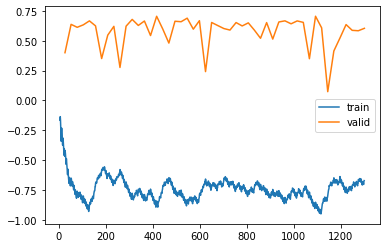

In [12]:
learn.recorder.plot_loss()

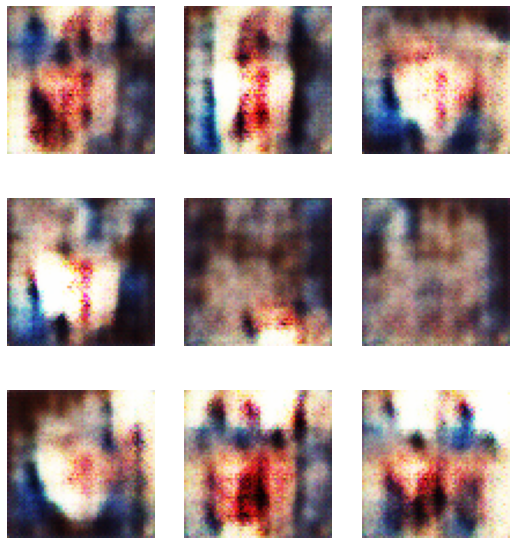

In [13]:
learn.show_results(max_n=9, ds_idx=0)

As you can see, the results are not the best right off the bat. You can get better results by training for longer, and finetuning the model more, but I think it is also important to show that GANs can take awhile to train. 

In [14]:
with learn.no_logging():
    with learn.no_bar():
        learn.fit(500, 2e-4, wd=0.)

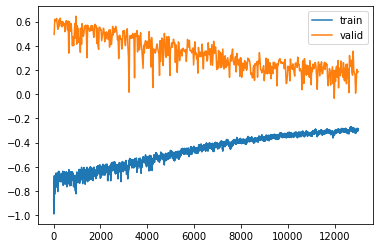

In [15]:
learn.recorder.plot_loss()

Here is what we get after 500 epochs. With this GAN I wouldn't expect great results. GANs in general have a lot of parameters and are hard to train. U-NET based GANS do fairly well for a low parameter Generators though. U-NETs are conditional Generators that take an image as an input. Feel free to look at other architectures as well, though know that they can take a long time to train. 

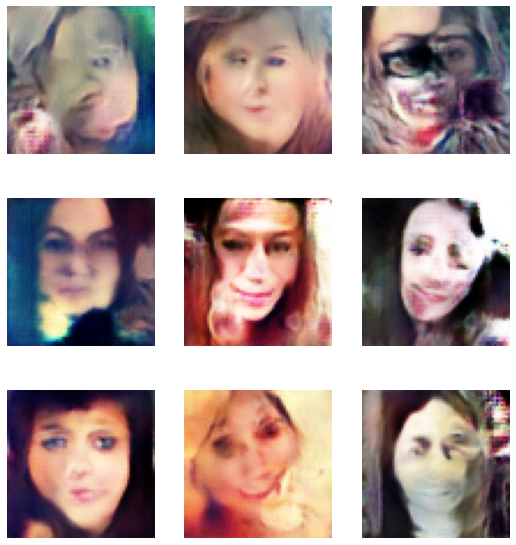

In [16]:
learn.show_results(max_n=9, ds_idx=0)

And here is the generator model architecture. This is just like a CNN, except that it uses ConvTranspose2D

In [17]:
learn.model.generator

Sequential(
  (0): AddChannels()
  (1): ConvLayer(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvLayer(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): ConvLayer(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1,

rand is going to be our input into our ConvTranspose layer. It is just random noise. 

In [18]:
rand=torch.randn([1,100],device=default_device())

Here we are using an identity matrix * 5, we are going to add this to blow up specific weights. This is just to show example of how the random input gets mapped to different features. 

In [19]:
ones = 5*torch.eye(100,device=default_device())
ones[0:5,0:5]

tensor([[5., 0., 0., 0., 0.],
        [0., 5., 0., 0., 0.],
        [0., 0., 5., 0., 0.],
        [0., 0., 0., 5., 0.],
        [0., 0., 0., 0., 5.]], device='cuda:0')

In [20]:
alter_single_params=(rand+ones)[0:10]
rand[:,0:10],alter_single_params[:,0:10]

(tensor([[ 0.9892, -0.3591, -0.2757, -0.1560,  0.6927,  1.3321, -1.4985,  0.6510,
           0.1489,  1.4966]], device='cuda:0'),
 tensor([[ 5.9892, -0.3591, -0.2757, -0.1560,  0.6927,  1.3321, -1.4985,  0.6510,
           0.1489,  1.4966],
         [ 0.9892,  4.6409, -0.2757, -0.1560,  0.6927,  1.3321, -1.4985,  0.6510,
           0.1489,  1.4966],
         [ 0.9892, -0.3591,  4.7243, -0.1560,  0.6927,  1.3321, -1.4985,  0.6510,
           0.1489,  1.4966],
         [ 0.9892, -0.3591, -0.2757,  4.8440,  0.6927,  1.3321, -1.4985,  0.6510,
           0.1489,  1.4966],
         [ 0.9892, -0.3591, -0.2757, -0.1560,  5.6927,  1.3321, -1.4985,  0.6510,
           0.1489,  1.4966],
         [ 0.9892, -0.3591, -0.2757, -0.1560,  0.6927,  6.3321, -1.4985,  0.6510,
           0.1489,  1.4966],
         [ 0.9892, -0.3591, -0.2757, -0.1560,  0.6927,  1.3321,  3.5015,  0.6510,
           0.1489,  1.4966],
         [ 0.9892, -0.3591, -0.2757, -0.1560,  0.6927,  1.3321, -1.4985,  5.6510,
           

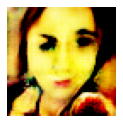

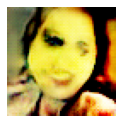

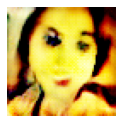

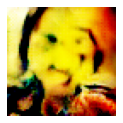

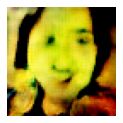

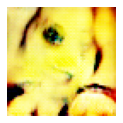

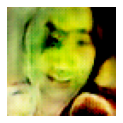

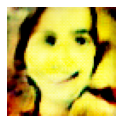

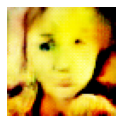

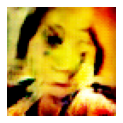

In [21]:
for img in learn.model.generator(alter_single_params).clamp(0,1):
    show_image(img)

Here we are slowing increasing the value of a single parameter, which slowly changes the output image in some way. There are other architectures that would have cleaner feature maps in the latent space than this one. 

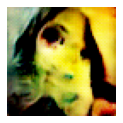

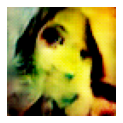

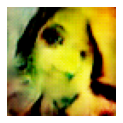

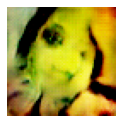

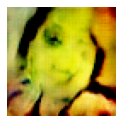

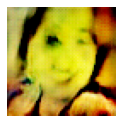

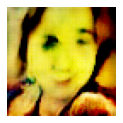

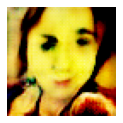

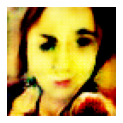

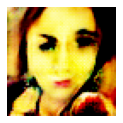

In [22]:
for i in range(10):
    img=learn.model.generator(rand+ones[:,0]*0.3*(i-5))[0].clamp(0,1)
    show_image(img)

In [24]:
def gen_loss(fake_pred, output, target): return fake_pred.mean()

In [25]:
def critic_loss(real_pred, fake_pred): return real_pred.mean() - fake_pred.mean()

This first module you will notice is AddChannels. This Module is simply responsible for simply making our noise into the correct shape for the following Conv Layer. Remember a ConvLayer expects a shape of *BatchSize x Channels x Width x Height*. We are going to reproduce this now. Later we will reproduce ConvTranspose using padding, and a regular Convolutional Layer. 

In [26]:
learn.model.generator

Sequential(
  (0): AddChannels()
  (1): ConvLayer(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ConvLayer(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvLayer(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): ConvLayer(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1,

In [27]:
class AddChannels(Module):
    "Add `n_dim` channels at the end of the input."
    def __init__(self, n_dim): self.n_dim=n_dim
    def forward(self, x): return x.view(*(list(x.shape)+[1]*self.n_dim))

In [33]:
x=dls.one_batch()[0]
n_dim=2
list(x.shape),list(x.shape)+[1]*n_dim

([128, 100], [128, 100, 1, 1])

In [34]:
x=AddChannels(2)(x)
x.shape

torch.Size([128, 100, 1, 1])

In [35]:
convT = nn.ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)

Below is the values we are trying to match using our padding+convultion approach. 

In [36]:
convT(x.cpu())[0,0,0:4,0:4]

tensor([[-0.0810,  0.0225, -0.0731,  0.0024],
        [-0.0440, -0.0085, -0.0398,  0.0384],
        [-0.0440, -0.0033,  0.0532,  0.1079],
        [ 0.0460,  0.0549,  0.0687, -0.0188]], grad_fn=<SelectBackward>)

Here we are pad every parameter of our input with a lot of zeroes, this will end up giving us a single specific weight from our weights. We are effectively multiply everything by a bunch of zeroes, so this is not how this tends to be done in practice. Though it helps to understand how we are doing this, because instead of a ConvTranspose a lot of the time we instead use Reflection Padding and a regular Convolutional Layer. 

In [37]:
x=F.pad(x, (3, 3, 3, 3), "constant", 0)
print(x[0][0])
print(x.shape)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -1.0047,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
torch.Size([128, 100, 7, 7])


In [38]:
F.conv2d(x.cpu(),convT.weight.transpose(0, 1).flip(2).flip(3))[0,0,0:4,0:4]

tensor([[-0.0810,  0.0225, -0.0731,  0.0024],
        [-0.0440, -0.0085, -0.0398,  0.0384],
        [-0.0440, -0.0033,  0.0532,  0.1079],
        [ 0.0460,  0.0549,  0.0687, -0.0188]], grad_fn=<SelectBackward>)

As you see these are the same, showing that we reemplemented ConvTRanspose in a similar, albeit inefficient way. Though, this gives us the intuitive understanding of why we did it this way. 

## Further Reading

If you would like to read more about GANs, then I would invite you to take a look at DeOldify(https://github.com/jantic/DeOldify). You can also take a look at last year's fastai GAN lesson https://course.fast.ai/videos/?lesson=7

In [106]:
export2html.notebook2html(fname='2020-06-11-Training-GANs.ipynb', dest='html/', template_file='fastpages.tpl',n_workers=1)

converting: 2020-06-11-Training-GANs.ipynb
